# Blood Cells - Object Count


We'll start with some imports and data preparation first

### Imports and loading 

In [ ]:
%matplotlib inline
import warnings
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import seaborn as sns
import pandas as pd
import torch
import glob
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image
import torchvision
from torchvision import datasets, models, transforms

warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
from zipfile import ZipFile

# !mkdir ./data

with ZipFile("./data.zip", "r") as zipObj:
    # Extract all the contents of zip file in current directory
    zipObj.extractall(path="./")

data_dir = r"./data/images/*"
labels_dir = r"./data/labels/*"


def load_image_dir(path, is_labels=False):
    samples = []
    files = glob.glob(path)
    files.sort()

    for filename in files:
        img = Image.open(filename, "r")
        img_gs = transforms.functional.rgb_to_grayscale(img)
        img_arr = np.asarray(img_gs)

        if is_labels:
            samples.append(np.count_nonzero(img_arr))
        else:
            samples.append(np.array(img_gs))
    samples = np.array(samples)
    return samples.reshape((samples.shape[0], 1)) if is_labels else samples


In [3]:
samples = load_image_dir(data_dir, is_labels=False)
labels = load_image_dir(labels_dir, is_labels=True)

train_samples = samples[:180]
train_labels = labels[:180]

test_samples = samples[180:]
test_labels = labels[180:]

In [4]:
train_samples.shape

(180, 256, 256)

In [5]:
np.array(train_samples[0])

array([[0, 0, 2, ..., 8, 7, 7],
       [1, 2, 1, ..., 8, 8, 7],
       [1, 1, 1, ..., 7, 7, 7],
       ...,
       [8, 6, 6, ..., 1, 2, 2],
       [6, 6, 6, ..., 1, 1, 1],
       [8, 7, 6, ..., 1, 1, 2]], dtype=uint8)

In [6]:
train_labels[:10]

array([[135],
       [233],
       [ 82],
       [ 86],
       [ 96],
       [143],
       [169],
       [122],
       [168],
       [115]])

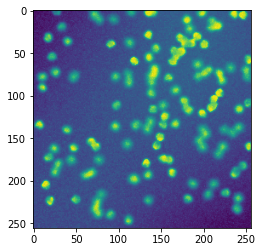

In [ ]:
def plot_np_arr_image(img_arr):
    plt.imshow(img_arr)
    plt.show()


plot_np_arr_image(train_samples[0])

In [ ]:
from torch.utils.data import Dataset

default_train_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.ToTensor(),
    ]
)
default_val_transforms = transforms.Compose([transforms.ToTensor()])


class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        #         self.data = data
        self.data = np.array(data)
        self.targets = torch.FloatTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)


train_dataset = MyDataset(
    train_samples, train_labels, transform=default_train_transforms
)
val_dataset = MyDataset(test_samples, test_labels, transform=default_val_transforms)


dataloaders = {
    "train": torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True),
    "val": torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False),
}

In [ ]:
for inputs, labels in dataloaders["train"]:
    print(inputs[0])
    print(labels)
    break

tensor([[[0.0157, 0.0196, 0.0118,  ..., 0.0078, 0.0000, 0.0000],
         [0.0157, 0.0157, 0.0157,  ..., 0.0000, 0.0039, 0.0039],
         [0.0118, 0.0157, 0.0157,  ..., 0.0078, 0.0078, 0.0039],
         ...,
         [0.0431, 0.0431, 0.0510,  ..., 0.0157, 0.0235, 0.0235],
         [0.0275, 0.0275, 0.0314,  ..., 0.0196, 0.0157, 0.0157],
         [0.0196, 0.0196, 0.0235,  ..., 0.0235, 0.0196, 0.0157]]])
tensor([[136.],
        [112.],
        [317.],
        [146.],
        [250.],
        [231.],
        [145.],
        [207.],
        [ 83.],
        [155.],
        [ 98.],
        [ 93.],
        [241.],
        [154.],
        [111.],
        [220.]])


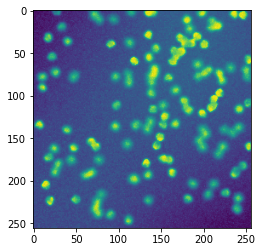

In [10]:
plot_np_arr_image(train_dataset.data[0])

In [11]:
# Check for the availability of a GPU, and use CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
dataset_sizes = {"train": len(train_samples), "val": len(test_samples)}
print("dataset_sizes: ", dataset_sizes)


dataset_sizes:  {'train': 180, 'val': 20}


Training and evaluation functions:

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_mse = np.inf
    best_mae = np.inf
    training_results = {p: [] for p in ["train", "val"]}

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                # Set model to training mode.
                model.train()
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()

            running_loss = 0.0
            running_mae = 0.0
            runnin_squared_error = 0.0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase == "train"):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    preds = model(inputs)  # apply the model to the inputs
                    loss = criterion(preds, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == "train":
                        loss.backward()  # Perform a step in the opposite direction of the gradient
                        optimizer.step()  # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                # print(f"Running loss: {running_loss}")
                runnin_squared_error += torch.sum(torch.pow(preds - labels, 2)).data
                # print(f"Running SE: {runnin_squared_error}")
                error = torch.abs(preds - labels).sum().data
                running_mae += error
                # print(f"Running MAE: {running_mae}")

            if phase == "train":
                # Adjust the learning rate based on the scheduler
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_mae = running_mae / dataset_sizes[phase]
            epoch_mse = runnin_squared_error / dataset_sizes[phase]
            training_results[phase].append(
                {"epoch": epoch, "epoch_loss": epoch_loss, "epoch_mse": epoch_mse}
            )

            print(f"{phase} Loss(MSE): {epoch_loss:.4f} MAE: {epoch_mae:.4f}")

            # Keep the results of the best model so far
            if phase == "val" and epoch_mae < best_mae:
                best_mse = epoch_mse
                best_mae = epoch_mae
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(
        f"Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s"
    )
    print(f"Best val MSE: {best_mse:4f}")
    print(f"Best val MAE: {best_mae:4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, training_results


def get_unified_stats_df(stats):
    train_stats_df = pd.DataFrame(stats["train"])
    train_stats_df["Dataset"] = "train"
    train_stats_df.epoch_mse = train_stats_df.epoch_mse.apply(
        lambda x: x.cpu().detach().numpy()
    )
    val_stats_df = pd.DataFrame(stats["val"])
    val_stats_df["Dataset"] = "validation"
    val_stats_df.epoch_mse = val_stats_df.epoch_mse.apply(
        lambda x: x.cpu().detach().numpy()
    )
    return pd.concat([train_stats_df, val_stats_df]).reset_index(drop=True)


def train_model_end2end(
    nn_obj, criterion, num_epochs, optimizer, dataloaders=dataloaders
):
    model = nn_obj.to(device)

    # Decay LR by a factor of 0.1 every 7 epochs - I did not change it as recommended in the above instructions
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    model, stats = train_model(
        model,
        dataloaders,
        criterion,
        optimizer,
        exp_lr_scheduler,
        num_epochs=num_epochs,
    )

    return model, stats

### Architecture


#### Final architecture implementation and base training

After playing with the above architecture, we see that we still have a rad flag that indicates **overfitting**:
- The train vs. validation accuracy has large gap (15%~)
- The train accuracy is almost perfect


Therfor we decided to try and handle this issue by adding 2 dropouts in the areas where the number of paramaters is the largest (between the last conv layer and the FC layer + between the 2 last FC layers).

In [ ]:
class FinalNetwork(nn.Module):
    """
    The final network that we decided to optimize
    """

    def __init__(self):
        super(FinalNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 5, stride=1, padding=2), nn.BatchNorm2d(32), nn.ReLU()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, 5, stride=1, padding=2), nn.BatchNorm2d(32), nn.ReLU()
        )

        self.layer3 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2), nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.BatchNorm2d(64), nn.ReLU()
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride=1, padding=1), nn.BatchNorm2d(64), nn.ReLU()
        )

        self.layer6 = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride=1, padding=1), nn.BatchNorm2d(64), nn.ReLU()
        )

        self.layer7 = nn.Sequential(nn.MaxPool2d(kernel_size=2, stride=2), nn.ReLU())

        self.layer8 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=1, padding=1), nn.BatchNorm2d(128), nn.ReLU()
        )

        self.layer9 = nn.Sequential(
            nn.Conv2d(128, 128, 3, stride=1, padding=1), nn.BatchNorm2d(128), nn.ReLU()
        )

        self.layer10 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2), nn.ReLU(), nn.Flatten()
        )

        self.dropout1 = nn.Dropout(p=0.3)

        self.fc1 = nn.Sequential(nn.Linear(128 * 32 * 32, 1024), nn.ReLU())

        self.dropout2 = nn.Dropout(p=0.3)

        self.fc2 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU())

        self.fc3 = nn.Sequential(nn.Linear(512, 16), nn.ReLU())

        self.fc4 = nn.Sequential(nn.Linear(16, 1), nn.ReLU())

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.dropout1(out)
        out = self.fc1(out)
        out = self.dropout2(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

In [ ]:
!pip install torchsummary 
from torchsummary import summary

summary(FinalNetwork().to(device), (1, 256, 256))

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             832
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]          25,632
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7         [-1, 32, 128, 128]               0
              ReLU-8         [-1, 32, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]          18,496
      BatchNorm2d-10         [-1, 64, 128, 128]             128
             ReLU-11         [-1, 64, 128, 128]               0
           Conv2d-12         [-1, 64, 128, 128]          36,928
      BatchNorm2d-1

In [16]:
torch.cuda.empty_cache()

In [ ]:
import gc

m1 = FinalNetwork()
m2 = FinalNetwork()

base_model_configurations = [
    {
        "config_name": "nn_base_w_dropout_adam",
        "params": {
            "nn_obj": m1,
            "criterion": nn.MSELoss(),
            "optimizer": optim.Adam(m1.parameters(), lr=0.00003),
            "num_epochs": 100,
        },
    },
    {
        "config_name": "nn_base_with_dropout_sgd_lr_1x10e7",
        "params": {
            "nn_obj": m2,
            "criterion": nn.MSELoss(),
            "optimizer": optim.SGD(m2.parameters(), lr=0.0000003, momentum=0.7),
            "num_epochs": 100,
        },
    },
]

base_results = []

for model_conf in base_model_configurations:
    conf_name = model_conf.get("config_name")
    params = model_conf.get("params")

    print(f"\n\nStarting to train model with conf name - {conf_name}")
    model, stats = train_model_end2end(**params)
    unified_stats_df = get_unified_stats_df(stats)
    base_results.append(
        (conf_name, copy.deepcopy(model.state_dict()), unified_stats_df)
    )

    del model
    gc.collect()
    torch.cuda.empty_cache()




Starting to train model with conf name - nn_base_w_dropout_adam
Epoch 0/99
----------
train Loss(MSE): 30454.4962 MAE: 164.1190
val Loss(MSE): 32279.1602 MAE: 167.2729
Epoch 1/99
----------
train Loss(MSE): 16761.7197 MAE: 118.2312
val Loss(MSE): 29157.8285 MAE: 157.7019
Epoch 2/99
----------
train Loss(MSE): 3681.3038 MAE: 47.8940
val Loss(MSE): 18009.7051 MAE: 119.8990
Epoch 3/99
----------
train Loss(MSE): 861.3040 MAE: 21.6892
val Loss(MSE): 4274.3360 MAE: 53.8432
Epoch 4/99
----------
train Loss(MSE): 387.7374 MAE: 14.6719
val Loss(MSE): 10857.9874 MAE: 95.5459
Epoch 5/99
----------
train Loss(MSE): 335.8236 MAE: 14.1061
val Loss(MSE): 7157.9799 MAE: 76.6654
Epoch 6/99
----------
train Loss(MSE): 335.6444 MAE: 14.4058
val Loss(MSE): 1849.6529 MAE: 38.7269
Epoch 7/99
----------
train Loss(MSE): 321.2008 MAE: 13.9158
val Loss(MSE): 329.2434 MAE: 15.8216
Epoch 8/99
----------
train Loss(MSE): 488.5784 MAE: 17.0133
val Loss(MSE): 64.2521 MAE: 5.6144
Epoch 9/99
----------
train Loss(

In [26]:
model1 = base_results[0][1]
m1 = FinalNetwork()
m1.load_state_dict(model1)

<All keys matched successfully>

In [27]:
filters = m1.layer1[0].weight.detach().numpy()

In [28]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [29]:
filters.shape

(32, 1, 5, 5)

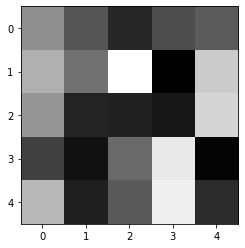

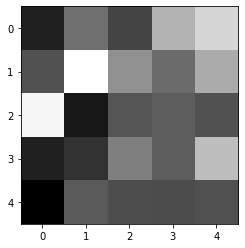

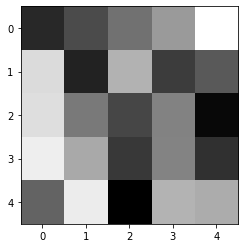

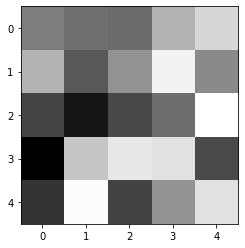

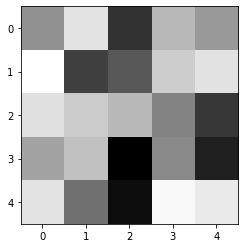

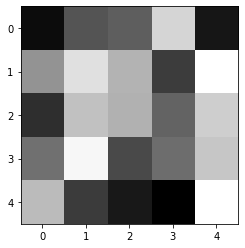

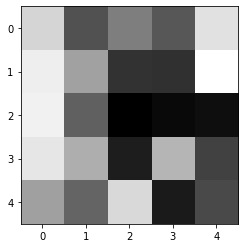

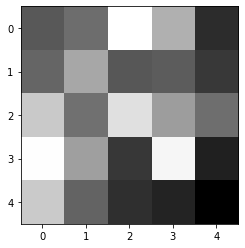

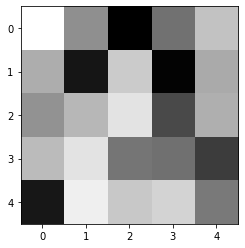

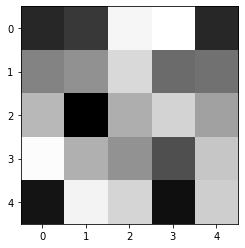

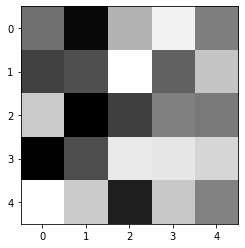

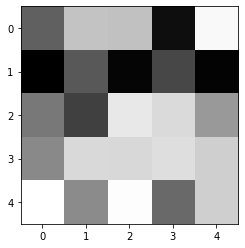

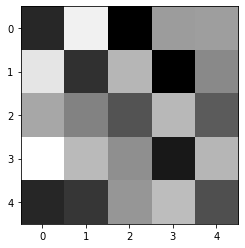

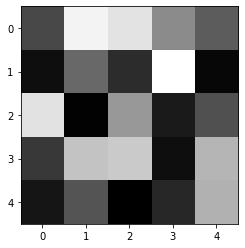

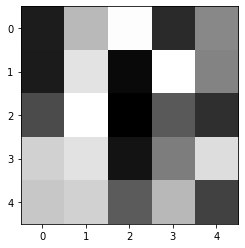

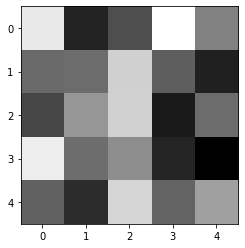

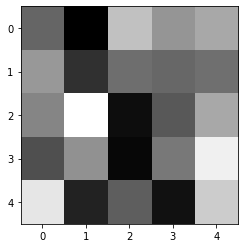

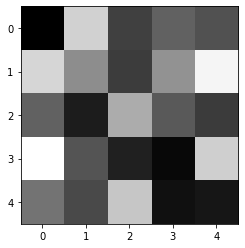

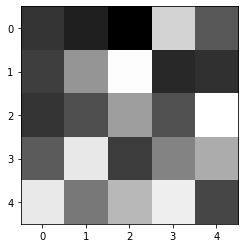

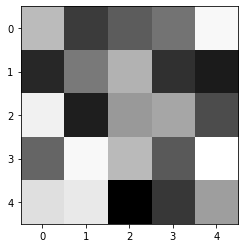

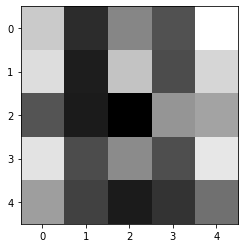

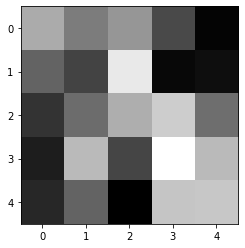

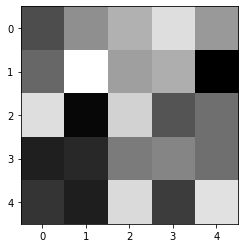

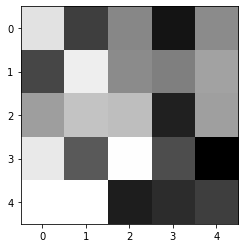

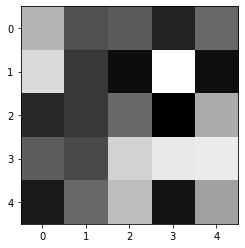

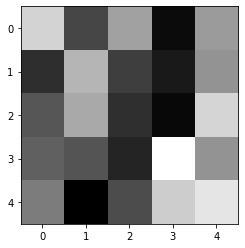

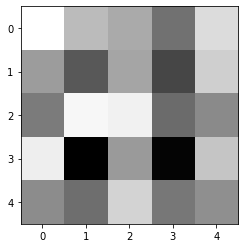

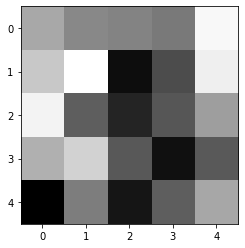

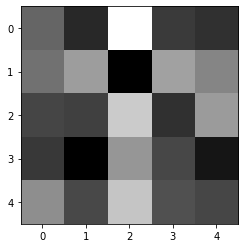

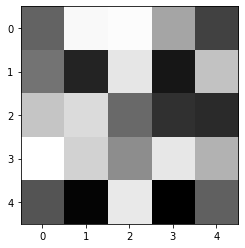

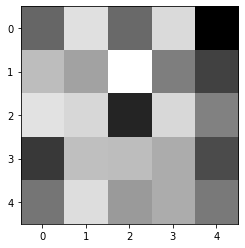

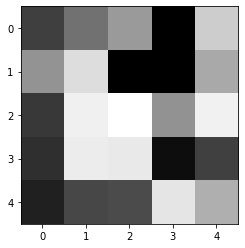

In [ ]:
for fs1 in filters:
    for fs2 in fs1:
        plt.imshow(fs2, cmap="gray")
        plt.show()

In [ ]:
def pytorch_predict(model, dataloader, device):
    """
    Make prediction from a pytorch model
    """
    # set model to evaluate model
    model.eval()

    y_true = torch.tensor([])
    y_pred = torch.tensor([])

    # deactivate autograd engine and reduce memory usage and speed up computations
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)

            y_true = torch.cat((y_true, labels), 0)
            y_pred = torch.cat((y_pred, outputs), 0)

    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    return y_true, y_pred

In [ ]:
model2 = base_results[1][1]
base_model = FinalNetwork()
base_model.load_state_dict(model2)
label, preds = pytorch_predict(base_model, dataloaders["val"], device)

pd.DataFrame(
    {
        "Label": label.reshape(-1),
        "Prediction": preds.reshape(-1),
        "Diff": np.abs(label.reshape(-1) - preds.reshape(-1)),
    }
)

,Label,Prediction,Diff
0,86.0,85.636223,0.363777
1,292.0,281.428894,10.571106
2,244.0,244.623856,0.623856
3,218.0,218.567123,0.567123
4,248.0,221.029755,26.970245
5,224.0,219.775101,4.224899
6,95.0,96.126617,1.126617
7,132.0,132.571091,0.571091
8,98.0,99.744804,1.744804
9,273.0,265.559814,7.440186
